In [2]:
import os
import sys
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, model_selection, metrics
import lightgbm as lgb

In [3]:
data_dir = 'data/'
print("Data Files are: ", os.listdir(data_dir))
train = pd.read_csv(data_dir + 'train.csv')
test = pd.read_csv(data_dir + 'test.csv')
print("Train DataFrame Shape: ", train.shape)
print("Test DataFrame Shape: ", test.shape)
train.head()

Data Files are:  ['sample_submission.csv.zip', 'test.csv', 'test.csv.zip', 'train.csv', 'train.csv.zip']
Train DataFrame Shape:  (4459, 4993)
Test DataFrame Shape:  (49342, 4992)


,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0


# Leaks in the Dataset

There exists leaks in the dataset as the columns and rows are both time-seires. The analysis are at:

Giba's Property:

https://www.kaggle.com/titericz/the-property-by-giba (kernel)

https://www.kaggle.com/c/santander-value-prediction-challenge/discussion/61329 (post)

And the analysis result used is at:

https://www.kaggle.com/johnfarrell/giba-s-property-extended-extended-result

https://www.kaggle.com/johnfarrell/breaking-lb-fresh-start-with-lag-selection

https://www.kaggle.com/johnfarrell/baseline-with-lag-select-fake-rows-dropped

In [4]:
#Row indexes(36)
row_l_index = [1757, 3809, 511, 3798, 625, 3303, 4095, 1283, 4209, 1696, 3511, 816, 245, 1383, 2071, 3492, 378, 2971, 
               2366, 4414, 2790, 3979, 193, 1189, 3516, 810, 4443, 3697, 235, 1382, 4384, 3418, 4396, 921, 3176, 650]

#Column indexes(40)
col_l_index = ['f190486d6', '58e2e02e6', 'eeb9cd3aa', '9fd594eec', '6eef030c1', '15ace8c9f', 'fb0f5dbfe', '58e056e12',
               '20aa07010', '024c577b9', 'd6bb78916', 'b43a7cfd5', '58232a6fb', '1702b5bf0', '324921c7b', '62e59a501', 
               '2ec5b290f', '241f0f867', 'fb49e4212', '66ace2992', 'f74e8f13d', '5c6487af1', '963a49cdc', '26fc93eb7', 
               '1931ccfdd', '703885424', '70feb1494', '491b9ee45', '23310aa6f', 'e176a204a', '6619d81fc', '1db387535', 
               'fc99f9426', '91f701ba2', '0572565c2', '190db8488', 'adb64ff71', 'c47340d97', 'c5a231d81', '0ff32eb98']

train.loc[row_l_index, col_l_index]

,f190486d6,58e2e02e6,eeb9cd3aa,9fd594eec,6eef030c1,15ace8c9f,fb0f5dbfe,58e056e12,20aa07010,024c577b9,...,6619d81fc,1db387535,fc99f9426,91f701ba2,0572565c2,190db8488,adb64ff71,c47340d97,c5a231d81,0ff32eb98
1757,1015000.00,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,...,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76
3809,540000.00,1015000.00,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,...,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76
511,115636.36,540000.00,1015000.00,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,...,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76
3798,834800.00,115636.36,540000.00,1015000.00,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,...,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76
625,296444.44,834800.00,115636.36,540000.00,1015000.00,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,...,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76
3303,247166.66,296444.44,834800.00,115636.36,540000.00,1015000.00,1563411.76,1563411.76,1563411.76,1563411.76,...,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76
4095,550000.00,247166.66,296444.44,834800.00,115636.36,540000.00,1015000.00,1563411.76,1563411.76,1563411.76,...,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76
1283,440000.00,3076666.66,550000.00,247166.66,296444.44,834800.00,115636.36,540000.00,1015000.00,1563411.76,...,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76
4209,0.00,440000.00,3076666.66,550000.00,247166.66,296444.44,834800.00,115636.36,540000.00,1015000.00,...,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76
1696,1600000.00,0.00,440000.00,3076666.66,550000.00,247166.66,296444.44,834800.00,115636.36,540000.00,...,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76,1563411.76


# Data Analysis
## Visualize data distribution

In [5]:
train = train[train.columns.drop(col_l_index)]

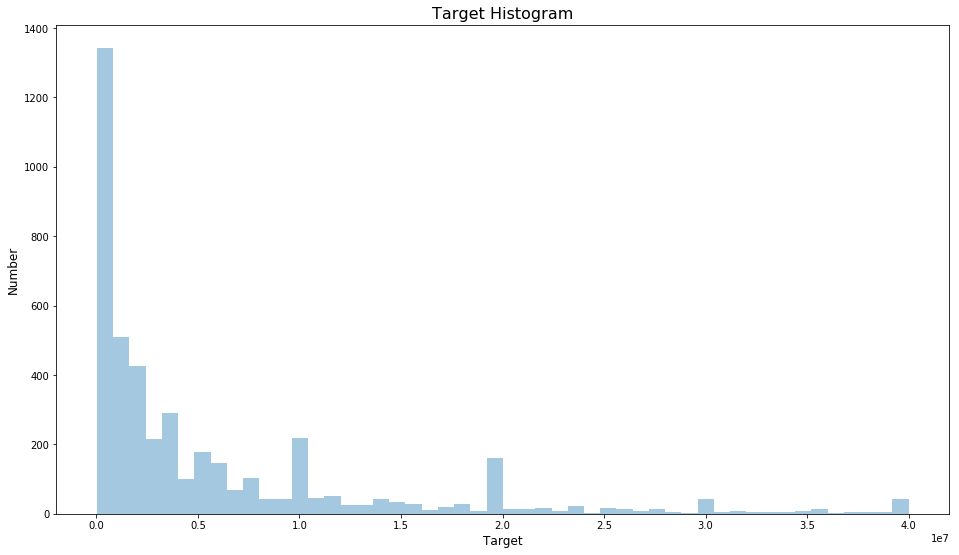

In [6]:
plt.figure(figsize=(16, 9))
sns.distplot(train["target"].values, bins=50, kde=False)
plt.xlabel('Target', fontsize=12)
plt.ylabel('Number', fontsize=12)
plt.title("Target Histogram", fontsize=16)
plt.show()

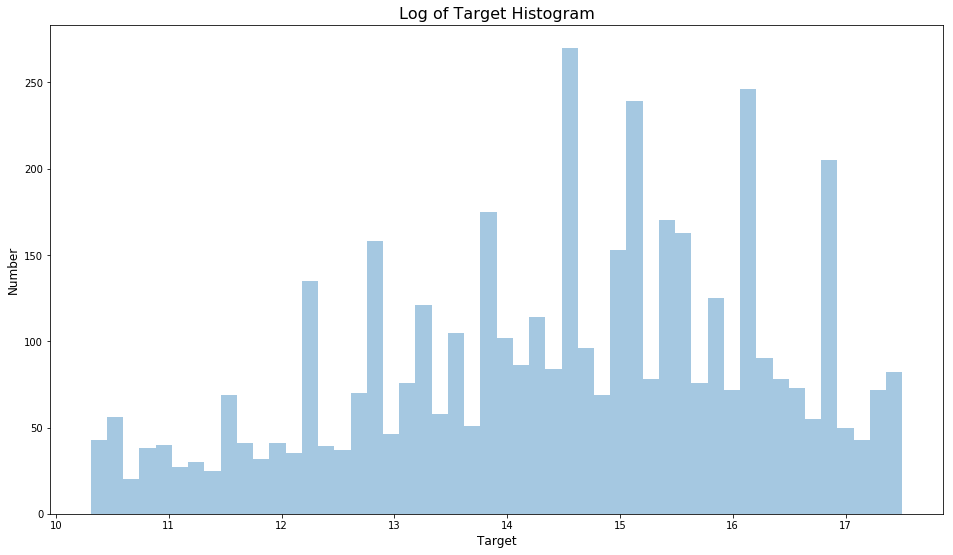

In [7]:
plt.figure(figsize=(16, 9))
sns.distplot(np.log(train["target"].values), bins=50, kde=False)
plt.xlabel('Target', fontsize=12)
plt.ylabel('Number', fontsize=12)
plt.title("Log of Target Histogram", fontsize=16)
plt.show()

In [8]:
# Print data type of each column
datatype = train.dtypes.reset_index()
datatype.groupby(0).aggregate('count')

,index
0,
int64,3147
float64,1805
object,1


In [9]:
# Detect columns with the constant value and drop them
uni_train = train.nunique().reset_index()
uni_train.columns = ["col", "uni_count"]
const_train = uni_train[uni_train["uni_count"] == 1]
const_train.shape
const_name = const_train.col.tolist()
train = train[train.columns.drop(const_name)]

## Calculate data Correlation

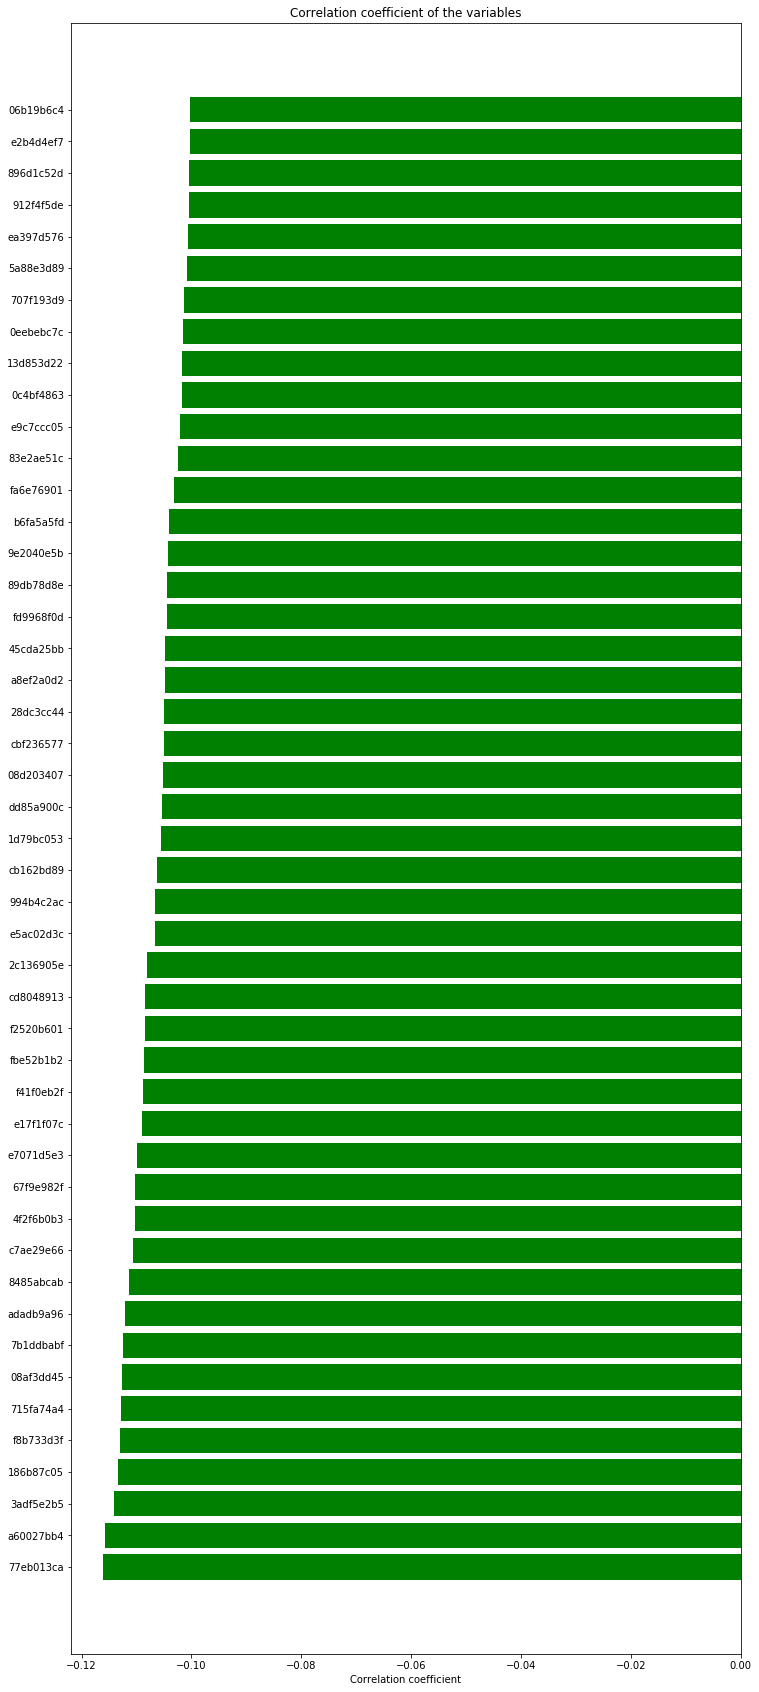

In [10]:
# Calculate spearman correlation between features and targets, plot and delete larger ones
from scipy.stats import spearmanr

correlation = [spearmanr(train['target'], train[c])[0] for c in train.columns.tolist()[2:]]
corr = pd.DataFrame({'col_name': train.columns.tolist()[2:], 'col_values': correlation}).sort_values(by='col_values')

corr = corr[(corr['col_values']>0.1) | (corr['col_values']<-0.1)]
ind = np.arange(corr.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,30))
rects = ax.barh(ind, np.array(corr.col_values.values), color='g')
ax.set_yticks(ind)
ax.set_yticklabels(corr.col_name.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
plt.show()

In [11]:
train = train[train.columns.drop(corr.col_name.tolist())]

## Calculate data Importance
#### Using RMSLE and LGBM

In [12]:
train_x = train[train.columns.tolist()[2:]]
train_y = np.log1p(train['target'])
test_x = test[test.columns.tolist()[1:]]

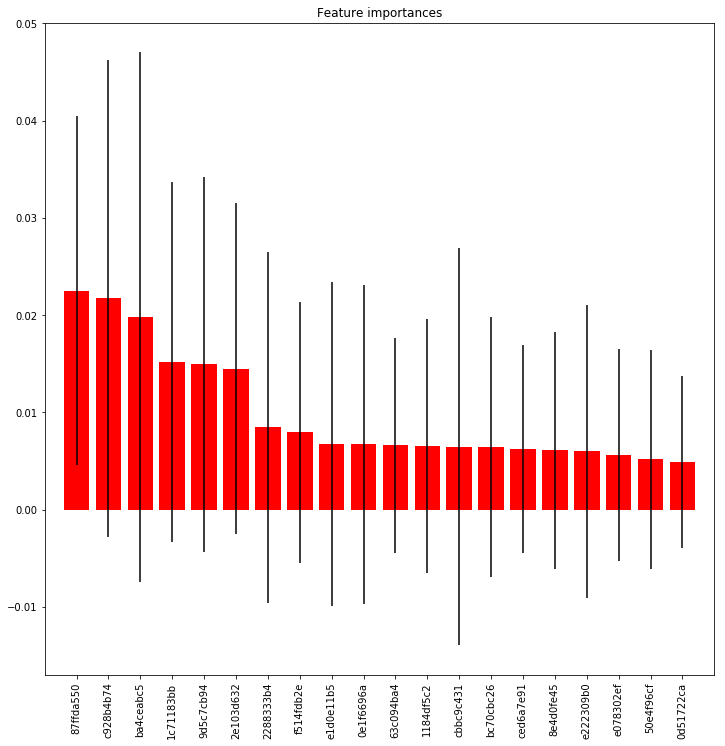

In [13]:
from sklearn import ensemble

# Use RMSLE to analysis the feature importance from the log target value
model = ensemble.ExtraTreesRegressor(n_estimators=200, max_depth=20, max_features=0.5, n_jobs=-1, random_state=0)
model.fit(train_x, train_y)

## plot the importances ##
feat_names = train_x.columns.values
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

In [14]:
# LGBM feature importance analysis
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=200, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

In [15]:
# Use KFold cross validation and average prediction of the test set
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
pred_test_full = 0
for dev_index, val_index in kf.split(train_x):
    dev_X, val_X = train_x.loc[dev_index,:], train_x.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_x)
    pred_test_full += pred_test
pred_test_full /= 5.
pred_test_full = np.expm1(pred_test_full)

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.48278
[400]	valid_0's rmse: 1.45759
Early stopping, best iteration is:
[473]	valid_0's rmse: 1.45695
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.47609
[400]	valid_0's rmse: 1.43635
[600]	valid_0's rmse: 1.42917
[800]	valid_0's rmse: 1.42771
Early stopping, best iteration is:
[716]	valid_0's rmse: 1.42708
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.48976
[400]	valid_0's rmse: 1.45667
[600]	valid_0's rmse: 1.4526
[800]	valid_0's rmse: 1.45095
[1000]	valid_0's rmse: 1.45014
Did not meet early stopping. Best iteration is:
[990]	valid_0's rmse: 1.45008
Training until validation scores don't improve for 100 rounds.
[200]	valid_0's rmse: 1.54116
[400]	valid_0's rmse: 1.50056
[600]	valid_0's rmse: 1.49077
[800]	valid_0's rmse: 1.48599
[1000]	valid_0's rmse: 1.48183
Did not meet early stopping. Best iteration is:
[1000]	vali

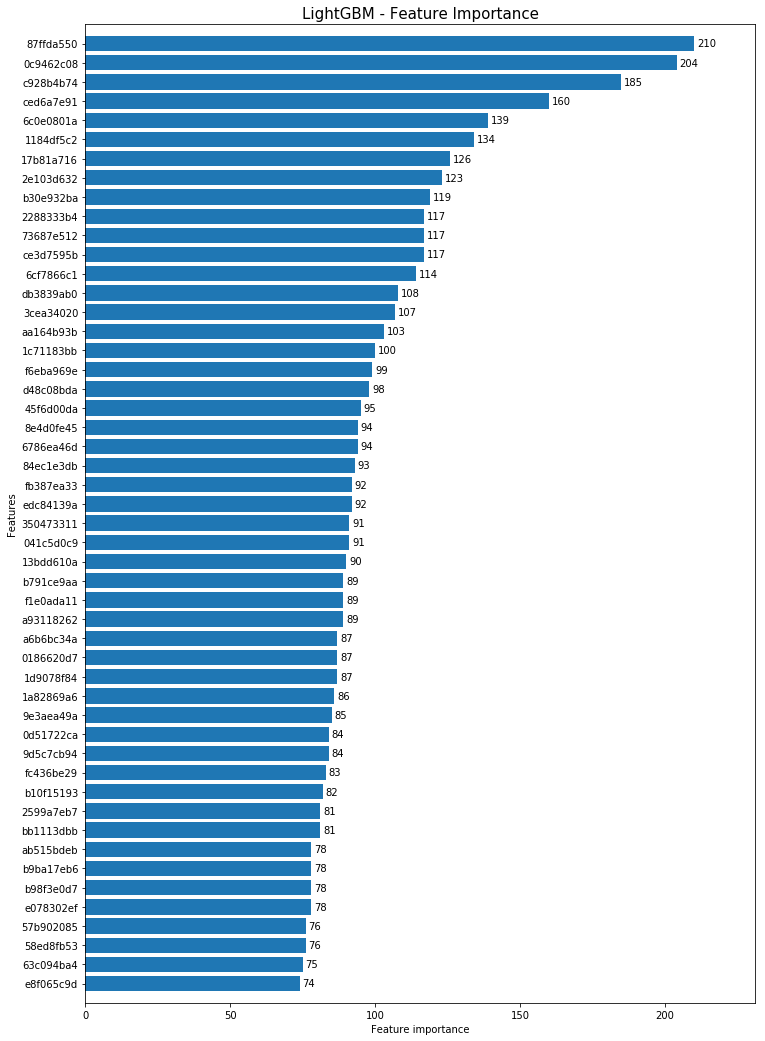

In [16]:
### Feature Importance ###
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()